<a href="https://colab.research.google.com/github/UzairRan/drug-shortage-predictor/blob/main/AI_Powered_Drug_Shortage_Prediction_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧠 AI-Powered Drug Shortage Prediction System


- Forecast essential drug shortages using past data sources.
- Utilize:
  - FDA Drug Shortage Reports (historical shortage status).
  - CMS Medicare Part D Utilization Data (prescription trends, costs, demographics).
- Support key stakeholders:
  - Pharmacy directors
  - Hospital procurement teams
  - Healthcare decision-makers
- Provide early warning insights to reduce supply chain disruptions.
- Apply machine learning and data analysis for predictive modeling.


💊 **1- FDA Drug Shortages Dataset:**  

This dataset lists drugs reported to be in shortage or resolved status, as classified by the FDA. It provides insight into which medications are currently facing supply issues in the U.S. market.


# Data Loading & Initial Exploration

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import roc_curve
import shap
from sklearn.metrics import mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
print("💊 Loading FDA Drug Shortage Dataset...")
from google.colab import files
uploaded = files.upload()


💊 Loading FDA Drug Shortage Dataset...


Saving Drug Shortages  FDA.csv to Drug Shortages  FDA.csv


In [3]:
# Load CSV into DataFrame
fda_filename = list(uploaded.keys())[0]  # Gets the uploaded file name dynamically
fda_df = pd.read_csv(fda_filename)

**Clean & preprocess FDA dataset**

In [4]:
# View first 5 rows of original data to understand its structure
print("Original data preview:")
display(fda_df.head())

Original data preview:


,Generic Name or Active Ingredient,Status
0,Albuterol Sulfate Solution,Currently in Shortage
1,Amino Acid Injection,Currently in Shortage
2,Amoxapine Tablet,Resolved
3,"Amoxicillin Powder, For Suspension",Resolved
4,"Amphetamine Aspartate Monohydrate, Amphetamine...",Currently in Shortage


In [5]:
# Rename columns for clarity
fda_df.columns = ['Drug_Name', 'Status']

In [6]:
# Rename columns for clarity
fda_df.columns = ['Drug_Name', 'Status']

# Map status to binary shortage flag: 1 if 'Currently in Shortage', else 0
fda_df['Shortage_Flag'] = fda_df['Status'].map({
    'Currently in Shortage': 1,
    'Resolved': 0
})

In [7]:
# Keep only relevant columns
fda_df = fda_df[['Drug_Name', 'Status', 'Shortage_Flag']]

**Basic dataset exploration after conversion**

In [8]:
print("FDA Dataset info:")
print(fda_df.info())

FDA Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Drug_Name      103 non-null    object
 1   Status         103 non-null    object
 2   Shortage_Flag  103 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 2.5+ KB
None


In [9]:
print("\nFirst 5 rows of FDA dataset:")
fda_df.head()



First 5 rows of FDA dataset:


,Drug_Name,Status,Shortage_Flag
0,Albuterol Sulfate Solution,Currently in Shortage,1
1,Amino Acid Injection,Currently in Shortage,1
2,Amoxapine Tablet,Resolved,0
3,"Amoxicillin Powder, For Suspension",Resolved,0
4,"Amphetamine Aspartate Monohydrate, Amphetamine...",Currently in Shortage,1


In [10]:
print("\nValue counts for shortage status:")
print(fda_df['Status'].value_counts())


Value counts for shortage status:
Status
Currently in Shortage    88
Resolved                 15
Name: count, dtype: int64


 **Clean & Explore FDA Drug Shortage Dataset**

In [11]:
# Check for missing values
print("🔍 Missing Values:\n", fda_df.isnull().sum())

🔍 Missing Values:
 Drug_Name        0
Status           0
Shortage_Flag    0
dtype: int64


In [12]:
# Drop duplicate rows if any
fda_df.drop_duplicates(inplace=True)

In [13]:
# Check the number of unique drugs
unique_drugs = fda_df['Drug_Name'].nunique()
print(f"\n📦 Unique Drugs: {unique_drugs}")


📦 Unique Drugs: 103


In [14]:
# Display count of unique statuses
print("\n📊 Status Counts:\n", fda_df['Status'].value_counts())


📊 Status Counts:
 Status
Currently in Shortage    88
Resolved                 15
Name: count, dtype: int64


In [15]:
# Check distribution of the binary flag
print("\n📊 Shortage Flag Distribution:\n", fda_df['Shortage_Flag'].value_counts())


📊 Shortage Flag Distribution:
 Shortage_Flag
1    88
0    15
Name: count, dtype: int64


 **Visualize Shortage Data**

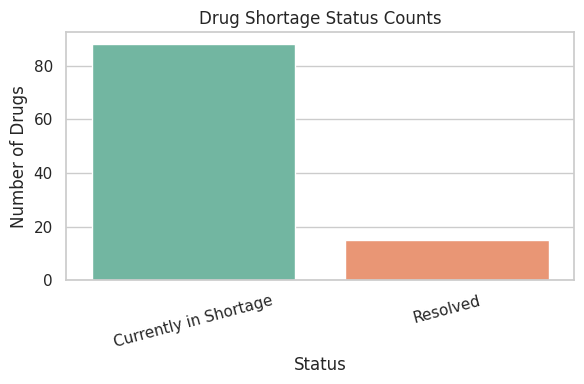

In [16]:
# Set visualization style
sns.set(style='whitegrid')

# Plot the counts of shortage vs resolved drugs
plt.figure(figsize=(6, 4))
sns.countplot(data=fda_df, x='Status', hue='Status', palette='Set2', legend=False)
plt.title('Drug Shortage Status Counts')
plt.xlabel('Status')
plt.ylabel('Number of Drugs')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

In [17]:
# Save cleaned FDA data for later use
fda_df.to_csv("fda_drug_shortages_cleaned.csv", index=False)
print("✅ Cleaned FDA dataset saved as 'fda_drug_shortages_cleaned.csv'")

✅ Cleaned FDA dataset saved as 'fda_drug_shortages_cleaned.csv'


In [18]:
# Show percentage distribution of shortage vs resolved
shortage_pct = fda_df['Shortage_Flag'].value_counts(normalize=True) * 100
print("Percentage Distribution:\n", shortage_pct)

Percentage Distribution:
 Shortage_Flag
1    85.436893
0    14.563107
Name: proportion, dtype: float64


✅ What We've Done So Far:
- Loaded the FDA Drug Shortage CSV into a DataFrame.

- Renamed columns for clarity.

- Converted the shortage status into a binary flag (1 = Shortage, 0 = Resolved).

- Added a placeholder date column for future time-based operations.

- Explored the dataset:

- No missing values.

- 103 unique drugs.

- 88 drugs currently in shortage (85.4%), 15 resolved.

- No duplicate entries.

📌 Summary of Key Results:

- Clean dataset with 4 columns: Drug_Name, Status, Shortage_Flag, Date.

- Binary flag distribution confirms a majority of drugs are currently in shortage.

- No missing or duplicate values, so the dataset is reliable for merging or modeling

 # FDA Model: Drug Shortage Classification

In [19]:
# ✅ Synthetic Monthly History for Better Temporal Learning
drug_names = fda_df['Drug_Name'].unique()
monthly_data = []

for drug in drug_names:
    for month in range(1, 7):  # Simulate 6 months of data
        # Simulate drugs going in/out of shortage (e.g., Months 3–5 = shortage)
        shortage_flag = 1 if month in [3, 4, 5] else 0
        monthly_data.append({
            'Drug_Name': drug,
            'Month': month,
            'Shortage_Flag': shortage_flag
        })

fda_monthly = pd.DataFrame(monthly_data)
print("✅ FDA dataset expanded with monthly history:", fda_monthly.shape)
print("Shortage distribution:\n", fda_monthly['Shortage_Flag'].value_counts())


✅ FDA dataset expanded with monthly history: (618, 3)
Shortage distribution:
 Shortage_Flag
0    309
1    309
Name: count, dtype: int64


In [20]:
#  Manual Drug Category Mapping (Improved Feature Engineering)
drug_categories = {
    'insulin': 'Diabetes',
    'metformin': 'Diabetes',
    'glipizide': 'Diabetes',
    'amox': 'Antibiotic',
    'penicillin': 'Antibiotic',
    'cephalosporin': 'Antibiotic',
    'heparin': 'Cardiovascular',
    'warfarin': 'Cardiovascular',
    'digoxin': 'Cardiovascular',
    'albuterol': 'Respiratory',
    'aminophylline': 'Respiratory'
}

def map_drug_category(name):
    name_lower = name.lower()
    for keyword, category in drug_categories.items():
        if keyword in name_lower:
            return category
    return 'Other'

fda_monthly['Drug_Category'] = fda_monthly['Drug_Name'].apply(map_drug_category)
fda_monthly = pd.get_dummies(fda_monthly, columns=['Drug_Category'], drop_first=True)

In [21]:
# Add additional synthetic features
fda_monthly['Name_Length'] = fda_monthly['Drug_Name'].str.len()
fda_monthly['Drug_Frequency'] = fda_monthly.groupby('Drug_Name')['Drug_Name'].transform('count')


In [22]:
# Final features
X = fda_monthly[['Month', 'Name_Length', 'Drug_Frequency']]
X = pd.get_dummies(X, columns=['Month'])
X = pd.concat([X, fda_monthly.filter(like='Drug_Category_')], axis=1)
X = X.values
y = fda_monthly['Shortage_Flag']

In [23]:
#  Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [24]:
#  Address Class Imbalance
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)

In [25]:
#  Train XGBoost with Best Practices
print("\n🧠 Training FDA Drug Shortage Classifier...")
model = XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=5,  # Adjust based on class imbalance
    eval_metric='auc',
    tree_method='hist',
    early_stopping_rounds=10,
    use_label_encoder=False
)
model.fit(X_res, y_res, eval_set=[(X_test, y_test)], verbose=False)


🧠 Training FDA Drug Shortage Classifier...


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [26]:
# Threshold Tuning (Using Youden's Index)
from sklearn.metrics import roc_curve

y_scores = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

preds_default = model.predict(X_test)
preds_optimal = (y_scores >= optimal_threshold).astype(int)

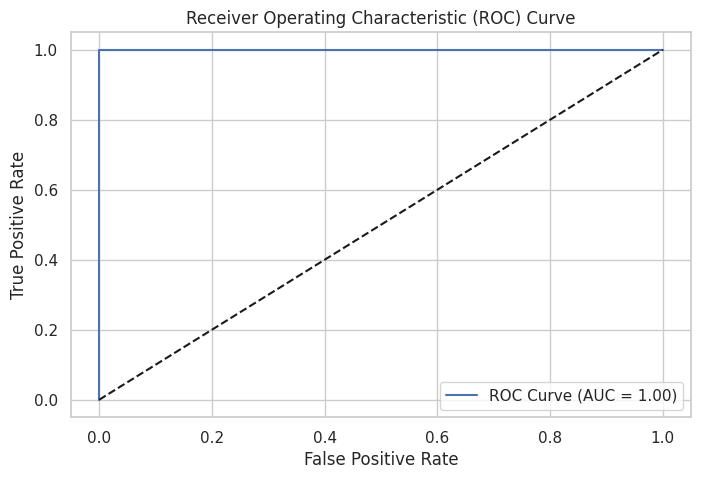

In [27]:
roc_auc = roc_auc_score(y_test, y_scores)

plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid(True)
plt.show()

In [28]:
# 8. Evaluation
print("\n🎯 FDA Model Performance:")
print("Classification Report (Default Threshold):")
print(classification_report(y_test, preds_default))

print("\n✅ Classification Report (Optimal Threshold):")
print(classification_report(y_test, preds_optimal))

print("\nROC AUC Score:", roc_auc_score(y_test, y_scores))



🎯 FDA Model Performance:
Classification Report (Default Threshold):
              precision    recall  f1-score   support

           0       1.00      0.56      0.72        62
           1       0.70      1.00      0.82        62

    accuracy                           0.78       124
   macro avg       0.85      0.78      0.77       124
weighted avg       0.85      0.78      0.77       124


✅ Classification Report (Optimal Threshold):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        62
           1       1.00      1.00      1.00        62

    accuracy                           1.00       124
   macro avg       1.00      1.00      1.00       124
weighted avg       1.00      1.00      1.00       124


ROC AUC Score: 1.0



📊 Generating Model Insights...


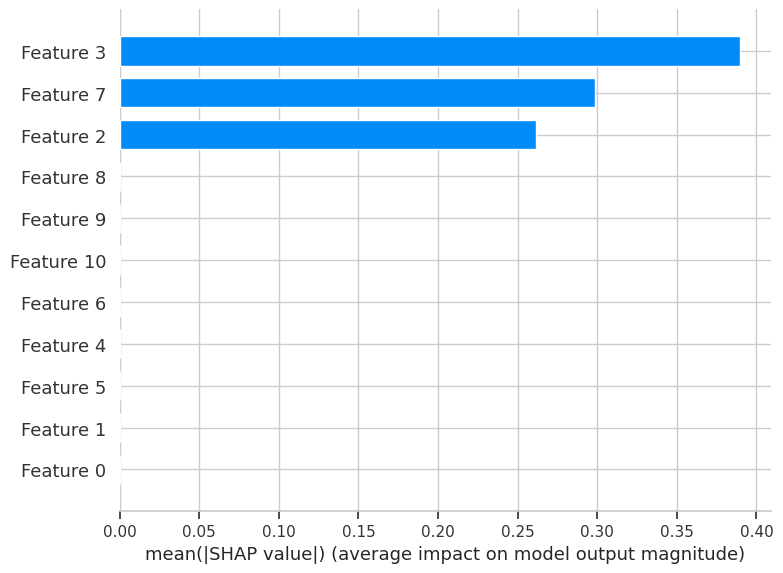

In [29]:
# SHAP Interpretability
print("\n📊 Generating Model Insights...")
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar", title="FDA Model: Key Features")


**Save FDA model and threshold**

In [30]:
import joblib
import os
import json

# Create models directory if needed
if not os.path.exists('models'):
    os.makedirs('models')

# Save XGBoost FDA model
joblib.dump(model, 'models/fda_classifier.pkl')

# Save optimal threshold for classification
with open('models/fda_optimal_threshold.json', 'w') as f:
    json.dump({'optimal_threshold': float(optimal_threshold)}, f)

print("✅ FDA classification model and threshold saved successfully!")


✅ FDA classification model and threshold saved successfully!


📄 **2- CMS Medicare Part D Utilization Dataset:**  

This dataset contains detailed information on drug usage, prescription volumes, and spending under Medicare Part D. Unlike the FDA dataset, which focuses on current shortages, this provides historical utilization trends per drug, which can help in understanding patterns linked to shortages.


In [31]:
!pip install optuna


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 17.0 MB/s eta 0:00:00


Before loading the cleaned CMS dataset, I first performed manual cleaning in Excel to remove

- unnecessary metadata,
- extra rows,
- and formatting issues.

 The initial dataset was very messy, containing multiple misaligned headers and redundant entries. While it's not yet fully cleaned, this basic preprocessing in Excel helps structure the data before further refinements in Python

In [46]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import optuna  # For hyperparameter tuning
import joblib
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping


Here different imports for different model are because I have used many models but they not give best results that are not fit for production environment

In [33]:
print("📁 Step 1: Uploading CMS Excel File")
from google.colab import files
uploaded = files.upload()

📁 Step 1: Uploading CMS Excel File


Saving CPS MDCR UTLZN D 2021.xlsx to CPS MDCR UTLZN D 2021.xlsx


In [34]:
# Get uploaded filename dynamically
cms_filename = list(uploaded.keys())[0]
print(f"✅ Uploaded file: {cms_filename}")

print("\n📊 Step 2: Basic Info About All CMS Sheets")

✅ Uploaded file: CPS MDCR UTLZN D 2021.xlsx

📊 Step 2: Basic Info About All CMS Sheets


In [35]:
# Load all sheets into a dictionary
xls = pd.ExcelFile(cms_filename)
sheet_names = xls.sheet_names
print("Available Sheets:", sheet_names)

Available Sheets: ['Table of Contents', 'MDCR UTLZN D 1', 'MDCR UTLZN D 2', 'MDCR UTLZN D 3', 'MDCR UTLZN D 4', 'MDCR UTLZN D 5', 'MDCR UTLZN D 6', 'MDCR UTLZN D 7', 'MDCR UTLZN D 8', 'MDCR UTLZN D 9', 'MDCR UTLZN D 10', 'MDCR UTLZN D 11']


In [36]:
# Skip 'Table of Contents' sheet
data_sheets = [sheet for sheet in sheet_names if sheet != "Table of Contents"]

# EDA for Excel sheets

In [37]:
# Load all sheets into a dictionary
xls = pd.ExcelFile(cms_filename)
sheet_names = xls.sheet_names
print("Available Sheets:", sheet_names)

# Skip 'Table of Contents' sheet
data_sheets = [sheet for sheet in sheet_names if sheet != "Table of Contents"]

# Loop through each data sheet and run EDA
for sheet in data_sheets:
    print(f"\n📘 Step 3: EDA for Sheet '{sheet}'")

    # Load sheet with header detection
    df = pd.read_excel(xls, sheet_name=sheet, header=None)

    # Find first non-empty row for header
    header_row = None
    for i, row in df.iterrows():
        if any(str(cell).strip() != '' for cell in row):
            header_row = i
            break

    if header_row is not None:
        # Set new header and clean column names
        df.columns = df.iloc[header_row].fillna('').astype(str).str.strip()
        df = df.iloc[header_row+1:].reset_index(drop=True)

        # Drop empty rows/columns
        df = df.dropna(how='all').dropna(axis=1, how='all')

        # Convert numeric columns to proper types
        for col in df.select_dtypes(include='object').columns:
            try:
                df[col] = pd.to_numeric(df[col].str.replace({',': '', r'\$': '', r'%': ''}, regex=True), errors='coerce')
            except:
                pass

        # Show basic info
        print(f"\n📌 First 5 Rows of '{sheet}':")
        display(df.head())
        print(f"🧾 Column Names: {df.columns.tolist()}")
        print(f"🚫 Missing Values:\n{df.isnull().sum()}")
        print(f"🔢 First Column Value Counts ('{df.columns[0]}'):")
        print(df[df.columns[0]].value_counts(dropna=False))
        print(f"📈 Summary Statistics for '{sheet}':")
        display(df.describe())

    else:
        print(f"❌ No valid header row found for sheet '{sheet}' — skipping")

Available Sheets: ['Table of Contents', 'MDCR UTLZN D 1', 'MDCR UTLZN D 2', 'MDCR UTLZN D 3', 'MDCR UTLZN D 4', 'MDCR UTLZN D 5', 'MDCR UTLZN D 6', 'MDCR UTLZN D 7', 'MDCR UTLZN D 8', 'MDCR UTLZN D 9', 'MDCR UTLZN D 10', 'MDCR UTLZN D 11']

📘 Step 3: EDA for Sheet 'MDCR UTLZN D 1'

📌 First 5 Rows of 'MDCR UTLZN D 1':


,Year,2016,2016,2016,2017,2017,2017,2018,2018,2018,2019,2019,2019,2020,2020,2020,2021,2021,2021
0,"Type of Plan, Rate, and Coverage",Total Part D,Stand-Alone Prescription Drug Plan,Medicare Advantage Prescription Drug Plan,Total Part D,Stand-Alone Prescription Drug Plan,Medicare Advantage Prescription Drug Plan,Total Part D,Stand-Alone Prescription Drug Plan,Medicare Advantage Prescription Drug Plan,Total Part D,Stand-Alone Prescription Drug Plan,Medicare Advantage Prescription Drug Plan,Total Part D,Stand-Alone Prescription Drug Plan,Medicare Advantage Prescription Drug Plan,Total Part D,Stand-Alone Prescription Drug Plan,Medicare Advantage Prescription Drug Plan
1,Overall Enrollees,41203627,24831079,16372548,42728443,25243684,17484759,44249461,25563945,18685516,45827091,25583137,20243954,47413121,25171949,22241173,48818849,24164736,24654113
2,Beneficiaries with No LIS,28787701,16626385,12161316,30474213,17449704,13024509,31365087,17753826,13611261,32767391,18170323,14597068,34274390,18361333,15913057,35675418,18097216,17578203
3,"Full LIS, Enrolled Beneficiaries",1086468,649894,436574,1014289,580763,433526,1103901,593191,510710,1094264,542393,551872,1112043,491780,620264,1108918,422621,686297
4,"Partial LIS, Enrolled Beneficiaries",413970,207612,206358,383811,185356,198455,406367,184654,221713,410245,170248,239996,371211,136380,234831,323250,101666,221583


🧾 Column Names: ['Year', '2016', '2016', '2016', '2017', '2017', '2017', '2018', '2018', '2018', '2019', '2019', '2019', '2020', '2020', '2020', '2021', '2021', '2021']
🚫 Missing Values:
0
Year    0
2016    0
2016    0
2016    0
2017    0
2017    0
2017    0
2018    0
2018    0
2018    0
2019    0
2019    0
2019    0
2020    0
2020    0
2020    0
2021    0
2021    0
2021    0
dtype: int64
🔢 First Column Value Counts ('Year'):
Year
Beneficiaries with No LIS                 6
Partial LIS, Enrolled Beneficiaries       6
Full LIS, Enrolled Beneficiaries          6
Beneficiaries Deemed Eligible for LIS²    6
Overall Utilizers                         4
Overall Enrollees                         2
Type of Plan, Rate, and Coverage          1
Name: count, dtype: int64
📈 Summary Statistics for 'MDCR UTLZN D 1':


,Year,2016,2016,2016,2017,2017,2017,2018,2018,2018,2019,2019,2019,2020,2020,2020,2021,2021,2021
count,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31
unique,7,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31
top,Beneficiaries with No LIS,Total Part D,Stand-Alone Prescription Drug Plan,Medicare Advantage Prescription Drug Plan,Total Part D,Stand-Alone Prescription Drug Plan,Medicare Advantage Prescription Drug Plan,Total Part D,Stand-Alone Prescription Drug Plan,Medicare Advantage Prescription Drug Plan,Total Part D,Stand-Alone Prescription Drug Plan,Medicare Advantage Prescription Drug Plan,Total Part D,Stand-Alone Prescription Drug Plan,Medicare Advantage Prescription Drug Plan,Total Part D,Stand-Alone Prescription Drug Plan,Medicare Advantage Prescription Drug Plan
freq,6,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1



📘 Step 3: EDA for Sheet 'MDCR UTLZN D 2'

📌 First 5 Rows of 'MDCR UTLZN D 2':


,Year,2016,2016,2016,2017,2017,2017,2018,2018,2018,2019,2019,2019,2020,2020,2020,2021,2021,2021
0,"Type of Plan, Low Income Subsidy (LIS) Eligibi...",Total Part D,Stand-Alone Prescription Drug Plan,Medicare Advantage Prescription Drug Plan,Total Part D,Stand-Alone Prescription Drug Plan,Medicare Advantage Prescription Drug Plan,Total Part D,Stand-Alone Prescription Drug Plan,Medicare Advantage Prescription Drug Plan,Total Part D,Stand-Alone Prescription Drug Plan,Medicare Advantage Prescription Drug Plan,Total Part D,Stand-Alone Prescription Drug Plan,Medicare Advantage Prescription Drug Plan,Total Part D,Stand-Alone Prescription Drug Plan,Medicare Advantage Prescription Drug Plan
1,Overall Enrollees,41203627,24831079,16372548,42728443,25243684,17484759,44249461,25563945,18685516,45827091,25583137,20243954,47413121,25171949,22241173,48818849,24164736,24654113
2,Beneficiaries with No LIS,28787701,16626385,12161316,30474213,17449704,13024509,31365087,17753826,13611261,32767391,18170323,14597068,34274390,18361333,15913057,35675418,18097216,17578203
3,"Full LIS, Enrolled Beneficiaries",1086468,649894,436574,1014289,580763,433526,1103901,593191,510710,1094264,542393,551872,1112043,491780,620264,1108918,422621,686297
4,"Partial LIS, Enrolled Beneficiaries",413970,207612,206358,383811,185356,198455,406367,184654,221713,410245,170248,239996,371211,136380,234831,323250,101666,221583


🧾 Column Names: ['Year', '2016', '2016', '2016', '2017', '2017', '2017', '2018', '2018', '2018', '2019', '2019', '2019', '2020', '2020', '2020', '2021', '2021', '2021']
🚫 Missing Values:
0
Year    0
2016    0
2016    0
2016    0
2017    0
2017    0
2017    0
2018    0
2018    0
2018    0
2019    0
2019    0
2019    0
2020    0
2020    0
2020    0
2021    0
2021    0
2021    0
dtype: int64
🔢 First Column Value Counts ('Year'):
Year
Full LIS, Enrolled Beneficiaries                                                             4
Beneficiaries with No LIS                                                                    4
Partial LIS, Enrolled Beneficiaries                                                          4
Beneficiaries Deemed Eligible for LIS¹                                                       4
Covered                                                                                      3
Non-Covered³                                                                              

,Year,2016,2016,2016,2017,2017,2017,2018,2018,2018,2019,2019,2019,2020,2020,2020,2021,2021,2021
count,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34
unique,18,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34
top,"Full LIS, Enrolled Beneficiaries",Total Part D,Stand-Alone Prescription Drug Plan,Medicare Advantage Prescription Drug Plan,Total Part D,Stand-Alone Prescription Drug Plan,Medicare Advantage Prescription Drug Plan,Total Part D,Stand-Alone Prescription Drug Plan,Medicare Advantage Prescription Drug Plan,Total Part D,Stand-Alone Prescription Drug Plan,Medicare Advantage Prescription Drug Plan,Total Part D,Stand-Alone Prescription Drug Plan,Medicare Advantage Prescription Drug Plan,Total Part D,Stand-Alone Prescription Drug Plan,Medicare Advantage Prescription Drug Plan
freq,4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1



📘 Step 3: EDA for Sheet 'MDCR UTLZN D 3'

📌 First 5 Rows of 'MDCR UTLZN D 3':


,Year,2016,2016,2016,2017,2017,2017,2018,2018,2018,2019,2019,2019,2020,2020,2020,2021,2021,2021
0,"Type of Plan, Low Income Subsidy (LIS) Eligibi...",Total Part D,Stand-Alone Prescription Drug Plan,Medicare Advantage Prescription Drug Plan,Total Part D,Stand-Alone Prescription Drug Plan,Medicare Advantage Prescription Drug Plan,Total Part D,Stand-Alone Prescription Drug Plan,Medicare Advantage Prescription Drug Plan,Total Part D,Stand-Alone Prescription Drug Plan,Medicare Advantage Prescription Drug Plan,Total Part D,Stand-Alone Prescription Drug Plan,Medicare Advantage Prescription Drug Plan,Total Part D,Stand-Alone Prescription Drug Plan,Medicare Advantage Prescription Drug Plan
1,Overall Utilizers,40520742,24429932,16090810,41967072,24771718,17195354,43521572,25090414,18431158,45065589,25085035,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Beneficiaries with No LIS,28191109,16481670,11709439,29703648,17225107,12478541,30717530,17600920,13116610,32091588,18000469,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"Full LIS, Enrolled Beneficiaries",1004170,569957,434213,1017660,549242,468418,1030310,519792,510518,1024202,471349,19980554,46240743,24439453,21801290,47644923,23444043,24200880
4,"Partial LIS, Enrolled Beneficiaries",420115,203667,216448,419313,195037,224276,416035,181652,234383,419500,166131,14091119,33241484,17999366,15242118,34609692,17755737,16853955


🧾 Column Names: ['Year', '2016', '2016', '2016', '2017', '2017', '2017', '2018', '2018', '2018', '2019', '2019', '2019', '2020', '2020', '2020', '2021', '2021', '2021']
🚫 Missing Values:
0
Year    8
2016    8
2016    8
2016    8
2017    8
2017    8
2017    8
2018    8
2018    8
2018    8
2019    8
2019    8
2019    8
2020    8
2020    8
2020    8
2021    8
2021    8
2021    8
dtype: int64
🔢 First Column Value Counts ('Year'):
Year
NaN                                                                                           8
Full LIS, Enrolled Beneficiaries                                                              4
Beneficiaries with No LIS                                                                     4
Beneficiaries Deemed Eligible for LIS¹                                                        4
Partial LIS, Enrolled Beneficiaries                                                           4
Covered                                                                              

,Year,2016,2016,2016,2017,2017,2017,2018,2018,2018,2019,2019,2019,2020,2020,2020,2021,2021,2021
count,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34
unique,18,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34
top,"Full LIS, Enrolled Beneficiaries",Total Part D,Stand-Alone Prescription Drug Plan,Medicare Advantage Prescription Drug Plan,Total Part D,Stand-Alone Prescription Drug Plan,Medicare Advantage Prescription Drug Plan,Total Part D,Stand-Alone Prescription Drug Plan,Medicare Advantage Prescription Drug Plan,Total Part D,Stand-Alone Prescription Drug Plan,Medicare Advantage Prescription Drug Plan,Total Part D,Stand-Alone Prescription Drug Plan,Medicare Advantage Prescription Drug Plan,Total Part D,Stand-Alone Prescription Drug Plan,Medicare Advantage Prescription Drug Plan
freq,4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1



📘 Step 3: EDA for Sheet 'MDCR UTLZN D 4'

📌 First 5 Rows of 'MDCR UTLZN D 4':


,Demographic Characteristics,Total Medicare Part D Enrollees,Prescription Drug Plan Enrollees,Medicare Advantage Prescription Drug Plan Enrollees,Overall Part D Average Drug Fills Per Part D Enrollee,Prescription Drug Plan Average Drug Fills Per Part D Enrollee,Medicare Advantage Prescription Drug Plan Average Drug Fills Per Part D Enrollee,Overall Part D Average Gross Drug Cost Per Part D Enrollee,Prescription Drug Plan Average Gross Drug Cost Per Part D Enrollee,Medicare Advantage Prescription Drug Plan Average Gross Drug Cost Per Part D Enrollee
0,Total,48818849,24164736,24654113,55.376089,54.368974,56.363212,4418.133139,4702.23688,4139.668775
1,Under 65 Years,6445656,2955457,3490200,65.07084,58.515053,70.622177,8589.162885,8985.313359,8253.705237
2,65 Years and Over,42373193,21209279,21163914,53.901358,53.791229,54.011724,3783.651265,4105.401488,3461.211368
3,Under 18 Years,939,912,27,45.37082,45.040789,56.518519,19181.403067,19300.437599,15160.681111
4,18-24 Years,78507,58512,19995,26.941618,25.358154,31.575357,5638.363451,5494.190806,6060.260415


🧾 Column Names: ['Demographic Characteristics', 'Total Medicare Part D Enrollees', 'Prescription Drug Plan Enrollees', 'Medicare Advantage Prescription Drug Plan Enrollees', 'Overall Part D  Average Drug Fills Per Part D Enrollee', 'Prescription Drug Plan Average Drug Fills Per Part D Enrollee', 'Medicare Advantage Prescription Drug Plan Average Drug Fills Per Part D Enrollee', 'Overall Part D  Average Gross Drug Cost Per Part D Enrollee', 'Prescription Drug Plan Average Gross Drug Cost Per Part D Enrollee', 'Medicare Advantage Prescription Drug Plan Average Gross Drug Cost Per Part D Enrollee']
🚫 Missing Values:
0
Demographic Characteristics                                                              0
Total Medicare Part D Enrollees                                                          0
Prescription Drug Plan Enrollees                                                         0
Medicare Advantage Prescription Drug Plan Enrollees                                      0
Overall Part 

,Demographic Characteristics,Total Medicare Part D Enrollees,Prescription Drug Plan Enrollees,Medicare Advantage Prescription Drug Plan Enrollees,Overall Part D Average Drug Fills Per Part D Enrollee,Prescription Drug Plan Average Drug Fills Per Part D Enrollee,Medicare Advantage Prescription Drug Plan Average Drug Fills Per Part D Enrollee,Overall Part D Average Gross Drug Cost Per Part D Enrollee,Prescription Drug Plan Average Gross Drug Cost Per Part D Enrollee,Medicare Advantage Prescription Drug Plan Average Gross Drug Cost Per Part D Enrollee
count,26,26,26,26,26.000000,26.000000,26.000000,26.000000,26.00000,26.000000
unique,26,26,26,26,26.000000,26.000000,26.000000,26.000000,26.00000,26.000000
top,Total,48818849,24164736,24654113,55.376089,54.368974,56.363212,4418.133139,4702.23688,4139.668775
freq,1,1,1,1,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000



📘 Step 3: EDA for Sheet 'MDCR UTLZN D 5'

📌 First 5 Rows of 'MDCR UTLZN D 5':


,Demographic Characteristics,Total Medicare Part D Utilizers,Prescription Drug Plan Utilizers,Medicare Advantage Prescription Drug Plan Utilizers,Overall Part D Average Drug Fills Per Utilizer,Prescription Drug Plan Average Drug Fills Per Utilizer,Medicare Advantage Prescription Drug Plan Average Drug Fills Per Utilizer,Overall Part D Average Gross Drug Cost Per Utilizer,Prescription Drug Plan Average Gross Drug Cost Per Utilizer,Medicare Advantage Prescription Drug Plan Average Gross Drug Cost Per Utilizer
0,Total,47644923,23444043,24200880,56.740503,56.04033,57.41878,4526.991776,4846.788279,4217.196307
1,Under 65 Years,6218734,2705439,3513295,67.445279,63.922611,70.157935,8902.581986,9815.674005,8199.448671
2,65 Years and Over,41426189,20738604,20687585,55.133545,55.012053,55.255337,3870.145653,4198.576026,3540.905318
3,Under 18 Years,1054,1024,30,40.420493,40.114453,50.866667,17088.555484,17189.452236,13644.613
4,18-24 Years,65388,46254,19134,32.346999,32.078444,32.996199,6769.606035,6950.23333,6332.962632


🧾 Column Names: ['Demographic Characteristics', 'Total Medicare Part D Utilizers', 'Prescription Drug Plan Utilizers', 'Medicare Advantage Prescription Drug Plan Utilizers', 'Overall Part D  Average Drug Fills Per Utilizer', 'Prescription Drug Plan Average Drug Fills Per Utilizer', 'Medicare Advantage Prescription Drug Plan Average Drug Fills Per Utilizer', 'Overall Part D  Average Gross Drug Cost Per Utilizer', 'Prescription Drug Plan Average Gross Drug Cost Per Utilizer', 'Medicare Advantage Prescription Drug Plan Average Gross Drug Cost Per Utilizer']
🚫 Missing Values:
0
Demographic Characteristics                                                       0
Total Medicare Part D Utilizers                                                   0
Prescription Drug Plan Utilizers                                                  0
Medicare Advantage Prescription Drug Plan Utilizers                               0
Overall Part D  Average Drug Fills Per Utilizer                                   0

,Demographic Characteristics,Total Medicare Part D Utilizers,Prescription Drug Plan Utilizers,Medicare Advantage Prescription Drug Plan Utilizers,Overall Part D Average Drug Fills Per Utilizer,Prescription Drug Plan Average Drug Fills Per Utilizer,Medicare Advantage Prescription Drug Plan Average Drug Fills Per Utilizer,Overall Part D Average Gross Drug Cost Per Utilizer,Prescription Drug Plan Average Gross Drug Cost Per Utilizer,Medicare Advantage Prescription Drug Plan Average Gross Drug Cost Per Utilizer
count,26,26,26,26,26.000000,26.00000,26.00000,26.000000,26.000000,26.000000
unique,26,26,26,26,26.000000,26.00000,26.00000,26.000000,26.000000,26.000000
top,Total,47644923,23444043,24200880,56.740503,56.04033,57.41878,4526.991776,4846.788279,4217.196307
freq,1,1,1,1,1.000000,1.00000,1.00000,1.000000,1.000000,1.000000



📘 Step 3: EDA for Sheet 'MDCR UTLZN D 6'

📌 First 5 Rows of 'MDCR UTLZN D 6':


,Area of Residence,Total Medicare Part D Enrollees,Prescription Drug Plan Enrollees,Medicare Advantage Prescription Drug Plan Enrollees,Overall Part D\n Average Drug Fills Per Part D Enrollee,Prescription Drug Plan\n Average Drug Fills Per Part D Enrollee,Medicare Advantage Prescription Drug Plan\n Average Drug Fills Per Part D Enrollee,Overall Part D\n Average Gross Drug Cost Per Part D Enrollee,Prescription Drug Plan \n Average Gross Drug Cost Per Part D Enrollee,Medicare Advantage Prescription Drug Plan\n Average Gross Drug Cost Per Part D Enrollee
0,All Areas,48818849,24164736,24654113,55.376089,54.368974,56.363212,4418.133132,4702.236913,4139.668733
1,United States,48165130,24135825,24029306,55.253151,54.393648,56.116463,4431.150039,4704.626978,4156.460809
2,Alabama,806300,290817,515483,63.942405,62.611567,64.693216,4958.953423,4884.47154,5000.973437
3,Alaska,70012,68782,1230,47.111865,47.240176,39.937624,4887.864797,4914.619537,3391.93373
4,Arizona,1068454,467625,600829,48.37621,45.09811,50.927554,3669.355391,3426.197064,3858.605409


🧾 Column Names: ['Area of Residence', 'Total Medicare Part D Enrollees', 'Prescription Drug Plan Enrollees', 'Medicare Advantage Prescription Drug Plan Enrollees', 'Overall Part D\n Average Drug Fills Per Part D Enrollee', 'Prescription Drug Plan\n Average Drug Fills Per Part D Enrollee', 'Medicare Advantage Prescription Drug Plan\n Average Drug Fills Per Part D Enrollee', 'Overall Part D\n Average Gross Drug Cost Per Part D Enrollee', 'Prescription Drug Plan \n Average Gross Drug Cost Per Part D Enrollee', 'Medicare Advantage Prescription Drug Plan\n Average Gross Drug Cost Per Part D Enrollee']
🚫 Missing Values:
0
Area of Residence                                                                          0
Total Medicare Part D Enrollees                                                            0
Prescription Drug Plan Enrollees                                                           0
Medicare Advantage Prescription Drug Plan Enrollees                                        0
Over

,Area of Residence,Total Medicare Part D Enrollees,Prescription Drug Plan Enrollees,Medicare Advantage Prescription Drug Plan Enrollees,Overall Part D\n Average Drug Fills Per Part D Enrollee,Prescription Drug Plan\n Average Drug Fills Per Part D Enrollee,Medicare Advantage Prescription Drug Plan\n Average Drug Fills Per Part D Enrollee,Overall Part D\n Average Gross Drug Cost Per Part D Enrollee,Prescription Drug Plan \n Average Gross Drug Cost Per Part D Enrollee,Medicare Advantage Prescription Drug Plan\n Average Gross Drug Cost Per Part D Enrollee
count,60,60,60,60,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000
unique,60,60,60,60,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000
top,All Areas,48818849,24164736,24654113,55.376089,54.368974,56.363212,4418.133132,4702.236913,4139.668733
freq,1,1,1,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000



📘 Step 3: EDA for Sheet 'MDCR UTLZN D 7'

📌 First 5 Rows of 'MDCR UTLZN D 7':


,Area of Residence,Total Medicare Part D Utilizers,Prescription Drug Plan Utilizers,Medicare Advantage Prescription Drug Plan Utilizers,Overall Part D\n Average Drug Fills Per Utilizer,Prescription Drug Plan\n Average Drug Fills Per Utilizer,Medicare Advantage Prescription Drug Plan\n Average Drug Fills Per Utilizer,Overall Part D\n Average Gross Drug Cost Per Utilizer,Prescription Drug Plan \n Average Gross Drug Cost Per Utilizer,Medicare Advantage Prescription Drug Plan\n Average Gross Drug Cost Per Utilizer
0,All Areas,47644923,23444043,24200880,56.740503,56.04033,57.41878,4526.991776,4846.788279,4217.196307
1,United States,46997113,23422326,23574787,56.626354,56.050605,57.198381,4541.277198,4847.940853,4236.596775
2,Alabama,801072,283796,517276,64.359736,64.160589,64.468995,4991.31888,5005.314289,4983.640501
3,Alaska,64703,63643,1060,50.977601,51.054693,46.348994,5288.935672,5311.461763,3936.456425
4,Arizona,1020000,441594,578406,50.674246,47.756519,52.901835,3843.662363,3628.161944,4008.189861


🧾 Column Names: ['Area of Residence', 'Total Medicare Part D Utilizers', 'Prescription Drug Plan Utilizers', 'Medicare Advantage Prescription Drug Plan Utilizers', 'Overall Part D\n Average Drug Fills Per Utilizer', 'Prescription Drug Plan\n Average Drug Fills Per Utilizer', 'Medicare Advantage Prescription Drug Plan\n Average Drug Fills Per Utilizer', 'Overall Part D\n Average Gross Drug Cost Per Utilizer', 'Prescription Drug Plan \n Average Gross Drug Cost Per Utilizer', 'Medicare Advantage Prescription Drug Plan\n Average Gross Drug Cost Per Utilizer']
🚫 Missing Values:
0
Area of Residence                                                                   0
Total Medicare Part D Utilizers                                                     0
Prescription Drug Plan Utilizers                                                    0
Medicare Advantage Prescription Drug Plan Utilizers                                 0
Overall Part D\n Average Drug Fills Per Utilizer                          

,Area of Residence,Total Medicare Part D Utilizers,Prescription Drug Plan Utilizers,Medicare Advantage Prescription Drug Plan Utilizers,Overall Part D\n Average Drug Fills Per Utilizer,Prescription Drug Plan\n Average Drug Fills Per Utilizer,Medicare Advantage Prescription Drug Plan\n Average Drug Fills Per Utilizer,Overall Part D\n Average Gross Drug Cost Per Utilizer,Prescription Drug Plan \n Average Gross Drug Cost Per Utilizer,Medicare Advantage Prescription Drug Plan\n Average Gross Drug Cost Per Utilizer
count,60,60,60,60,60.000000,60.00000,60.00000,60.000000,60.000000,60.000000
unique,60,60,60,60,60.000000,60.00000,60.00000,60.000000,60.000000,60.000000
top,All Areas,47644923,23444043,24200880,56.740503,56.04033,57.41878,4526.991776,4846.788279,4217.196307
freq,1,1,1,1,1.000000,1.00000,1.00000,1.000000,1.000000,1.000000



📘 Step 3: EDA for Sheet 'MDCR UTLZN D 8'

📌 First 5 Rows of 'MDCR UTLZN D 8':


,Year,2016,2016,2016,2017,2017,2017,2018,2018,2018,2019,2019,2019,2020,2020,2020,2021,2021,2021
0,"Type of Plan, Rate, and Part D Coverage Phase",Total Part D,Stand-Alone Prescription Drug Plan,Medicare Advantage Prescription Drug Plan,Total Part D,Stand-Alone Prescription Drug Plan,Medicare Advantage Prescription Drug Plan,Total Part D,Stand-Alone Prescription Drug Plan,Medicare Advantage Prescription Drug Plan,Total Part D,Stand-Alone Prescription Drug Plan,Medicare Advantage Prescription Drug Plan,Total Part D,Stand-Alone Prescription Drug Plan,Medicare Advantage Prescription Drug Plan,Total Part D,Stand-Alone Prescription Drug Plan,Medicare Advantage Prescription Drug Plan
1,Overall Utilizers,40520742,24429932,16090810,41967072,24771718,17195354,43521572,25090414,18431158,45065589,25085035,19980554,46240743,24439453,21801290,,,
2,Beneficiaries with No LIS,28191109,16481670,11709439,29703648,17225107,12478541,30717530,17600920,13116610,32091588,18000469,14091119,33241484,17999366,15242118,47644923,23444043,24200880
3,"Full LIS, Enrolled Beneficiaries",1004170,569957,434213,1017660,549242,468418,1030310,519792,510518,1024202,471349,552853,1021439,415551,605888,34609692,17755737,16853955
4,"Partial LIS, Enrolled Beneficiaries",420115,203667,216448,419313,195037,224276,416035,181652,234383,419500,166131,253369,392291,136437,255854,1031177,355728,675449


🧾 Column Names: ['Year', '2016', '2016', '2016', '2017', '2017', '2017', '2018', '2018', '2018', '2019', '2019', '2019', '2020', '2020', '2020', '2021', '2021', '2021']
🚫 Missing Values:
0
Year    0
2016    1
2016    1
2016    1
2017    1
2017    1
2017    1
2018    1
2018    1
2018    1
2019    1
2019    1
2019    1
2020    1
2020    1
2020    1
2021    5
2021    5
2021    5
dtype: int64
🔢 First Column Value Counts ('Year'):
Year
Full LIS, Enrolled Beneficiaries                                                                                          12
Beneficiaries with No LIS                                                                                                 12
Beneficiaries Deemed Eligible for LIS³                                                                                    12
Partial LIS, Enrolled Beneficiaries                                                                                       12
Average Prescription Drug Events (Fills) per Utilizer            

,Year,2016,2016,2016,2017,2017,2017,2018,2018,2018,2019,2019,2019,2020,2020,2020,2021,2021,2021
count,62,61,61,61,61,61,61,61,61,61,61,61.00,61,61,61,61,57,57,57
unique,8,61,61,61,61,61,61,61,61,61,61,60.00,61,61,61,61,57,57,57
top,"Full LIS, Enrolled Beneficiaries",Total Part D,Stand-Alone Prescription Drug Plan,Medicare Advantage Prescription Drug Plan,Total Part D,Stand-Alone Prescription Drug Plan,Medicare Advantage Prescription Drug Plan,Total Part D,Stand-Alone Prescription Drug Plan,Medicare Advantage Prescription Drug Plan,Total Part D,54.68,Medicare Advantage Prescription Drug Plan,Total Part D,Stand-Alone Prescription Drug Plan,Medicare Advantage Prescription Drug Plan,Total Part D,Stand-Alone Prescription Drug Plan,Medicare Advantage Prescription Drug Plan
freq,12,1,1,1,1,1,1,1,1,1,1,2.00,1,1,1,1,1,1,1



📘 Step 3: EDA for Sheet 'MDCR UTLZN D 9'

📌 First 5 Rows of 'MDCR UTLZN D 9':


,Year,2016,2016,2016,2017,2017,2017,2018,2018,2018,2019,2019,2019,2020,2020,2020,2021,2021,2021
0,"Type of Part D Plan, Low Income Subsidy (LIS)...",Total Part D,Stand-Alone Prescription Drug Plan,Medicare Advantage Prescription Drug Plan,Total Part D,Stand-Alone Prescription Drug Plan,Medicare Advantage Prescription Drug Plan,Total Part D,Stand-Alone Prescription Drug Plan,Medicare Advantage Prescription Drug Plan,Total Part D,Stand-Alone Prescription Drug Plan,Medicare Advantage Prescription Drug Plan,Total Part D,Stand-Alone Prescription Drug Plan,Medicare Advantage Prescription Drug Plan,Total Part D,Stand-Alone Prescription Drug Plan,Medicare Advantage Prescription Drug Plan
1,Overall Utilizers,40520742,24429932,16090810,41967072,24771718,17195354,43521572,25090414,18431158,45065589,25085035,19980554,46240743,24439453,21801290,47644923,23444043,24200880
2,Beneficiaries with No LIS,28191109,16481670,11709439,29703648,17225107,12478541,30717530,17600920,13116610,32091588,18000469,14091119,33241484,17999366,15242118,34609692,17755737,16853955
3,"Full LIS, Enrolled Beneficiaries",1004170,569957,434213,1017660,549242,468418,1030310,519792,510518,1024202,471349,552853,1021439,415551,605888,1031177,355728,675449
4,"Partial LIS, Enrolled Beneficiaries",420115,203667,216448,419313,195037,224276,416035,181652,234383,419500,166131,253369,392291,136437,255854,350892,103019,247873


🧾 Column Names: ['Year', '2016', '2016', '2016', '2017', '2017', '2017', '2018', '2018', '2018', '2019', '2019', '2019', '2020', '2020', '2020', '2021', '2021', '2021']
🚫 Missing Values:
0
Year    0
2016    0
2016    0
2016    0
2017    0
2017    0
2017    0
2018    0
2018    0
2018    0
2019    0
2019    0
2019    0
2020    0
2020    0
2020    0
2021    0
2021    0
2021    0
dtype: int64
🔢 First Column Value Counts ('Year'):
Year
Beneficiaries Deemed Eligible for LIS²                                                   12
Partial LIS, Enrolled Beneficiaries                                                      12
Full LIS, Enrolled Beneficiaries                                                         12
Beneficiaries with No LIS                                                                10
Overall Utilizers                                                                         6
Average Drug Cost Per Utilizer                                                            5
Overall Drug 

,Year,2016,2016,2016,2017,2017,2017,2018,2018,2018,2019,2019,2019,2020,2020,2020,2021,2021,2021
count,67,67,67,67,67,67,67,67,67,67,67,67,67,67,67,67,67,67,67
unique,11,67,67,67,67,67,66,65,67,67,67,67,67,66,67,67,67,66,67
top,Beneficiaries Deemed Eligible for LIS²,Total Part D,Stand-Alone Prescription Drug Plan,Medicare Advantage Prescription Drug Plan,Total Part D,Stand-Alone Prescription Drug Plan,5514,4101,Stand-Alone Prescription Drug Plan,Medicare Advantage Prescription Drug Plan,Total Part D,Stand-Alone Prescription Drug Plan,Medicare Advantage Prescription Drug Plan,301,Stand-Alone Prescription Drug Plan,Medicare Advantage Prescription Drug Plan,Total Part D,247,Medicare Advantage Prescription Drug Plan
freq,12,1,1,1,1,1,2,2,1,1,1,1,1,2,1,1,1,2,1



📘 Step 3: EDA for Sheet 'MDCR UTLZN D 10'

📌 First 5 Rows of 'MDCR UTLZN D 10':


,Demographic Characteristics,Total Medicare Part D Utilizers²,Overall Part D Average Drug Fills Per Utilizer²,Overall Part D Average Gross Drug Cost Per Utilizer²,Medicare Part D Utilizers in Deductible Phase,Part D Average Drug Fills per Utilizer in Deductible Phase,Part D Average Gross Drug Cost Per Utilizer in Deductible Phase,Medicare Part D Utilizers in Initial Coverage Phase,Part D Average Drug Fills per Utilizer in Initial Coverage Phase,Part D Average Gross Drug Cost Per Utilizer in Initial Coverage Phase,Medicare Part D Utilizers who Reached Coverage Gap Phase,Part D Average Drug Fills per Utilizer Who Reached Coverage Gap Phase,Part D Average Gross Drug Cost Per Utilizer Who Reached Coverage Gap Phase,Medicare Part D Utilizers who Entered Catastrophic Coverage Phase,Part D Average Drug Fills per Utilizer who Entered Catastrophic Coverage Phase,Part D Average Gross Drug Cost Per Utilizer who Entered Catastrophic Coverage Phase,Utilizers Enrolled in Employer Group Waiver Plans³,Part D Average Drug Fills per Utilizer Enrolled in Employer Group Waiver Plans³,Part D Average Gross Drug Cost Per Utilizer Enrolled in Employer Group Waiver Plans³
0,Total,47644923,56.74,4527,13977265,32.8,266,16876261,54.85,1230,5793142,84.52,6565,3629272,115.69,32193,7315632,55.1,4906
1,Under 65 Years,6218734,67.45,8903,1387063,25.36,257,2473383,58.34,1485,925315,89.45,6549,1258832,115.43,34600,169441,65.98,9784
2,65 Years and Over,41426189,55.13,3870,12590202,33.62,267,14402878,54.24,1186,4867827,83.58,6568,2370440,115.82,30915,7146191,54.85,4790
3,Under 18 Years,1054,40.42,17089,170,10.79,175,327,30.38,1860,210,44.73,6606,346,61.68,46103,*,100.27,34694
4,18-24 Years,65388,32.35,6770,27109,10.65,161,22598,36.84,1514,6165,58.34,6436,8991,68.45,40129,†,36.42,6922


🧾 Column Names: ['Demographic Characteristics', 'Total Medicare Part D Utilizers²', 'Overall Part D Average Drug Fills Per Utilizer²', 'Overall Part D Average Gross Drug Cost Per Utilizer²', 'Medicare Part D Utilizers in Deductible Phase', 'Part D Average Drug Fills per Utilizer in Deductible Phase', 'Part D Average Gross Drug Cost Per Utilizer in Deductible Phase', 'Medicare Part D Utilizers in Initial Coverage Phase', 'Part D Average Drug Fills per Utilizer in Initial Coverage Phase', 'Part D Average Gross Drug Cost Per Utilizer in Initial Coverage Phase', 'Medicare Part D Utilizers who Reached Coverage Gap Phase', 'Part D Average Drug Fills per Utilizer Who Reached Coverage Gap Phase', 'Part D Average Gross Drug Cost Per Utilizer Who Reached Coverage Gap Phase', 'Medicare Part D Utilizers who Entered Catastrophic Coverage Phase', 'Part D Average Drug Fills per Utilizer who Entered Catastrophic Coverage Phase', 'Part D Average Gross Drug Cost Per Utilizer who Entered Catastrophic Cov

,Demographic Characteristics,Total Medicare Part D Utilizers²,Overall Part D Average Drug Fills Per Utilizer²,Overall Part D Average Gross Drug Cost Per Utilizer²,Medicare Part D Utilizers in Deductible Phase,Part D Average Drug Fills per Utilizer in Deductible Phase,Part D Average Gross Drug Cost Per Utilizer in Deductible Phase,Medicare Part D Utilizers in Initial Coverage Phase,Part D Average Drug Fills per Utilizer in Initial Coverage Phase,Part D Average Gross Drug Cost Per Utilizer in Initial Coverage Phase,Medicare Part D Utilizers who Reached Coverage Gap Phase,Part D Average Drug Fills per Utilizer Who Reached Coverage Gap Phase,Part D Average Gross Drug Cost Per Utilizer Who Reached Coverage Gap Phase,Medicare Part D Utilizers who Entered Catastrophic Coverage Phase,Part D Average Drug Fills per Utilizer who Entered Catastrophic Coverage Phase,Part D Average Gross Drug Cost Per Utilizer who Entered Catastrophic Coverage Phase,Utilizers Enrolled in Employer Group Waiver Plans³,Part D Average Drug Fills per Utilizer Enrolled in Employer Group Waiver Plans³,Part D Average Gross Drug Cost Per Utilizer Enrolled in Employer Group Waiver Plans³
count,26,26,26.00,26,26,26.0,26,26,26.00,26,26,26.00,26,26,26.00,26,26,26.0,26
unique,26,26,26.00,26,26,26.0,24,26,26.00,26,26,26.00,24,26,26.00,26,26,26.0,26
top,Total,47644923,56.74,4527,13977265,32.8,266,16876261,54.85,1230,5793142,84.52,6549,3629272,115.69,32193,7315632,55.1,4906
freq,1,1,1.00,1,1,1.0,2,1,1.00,1,1,1.00,2,1,1.00,1,1,1.0,1



📘 Step 3: EDA for Sheet 'MDCR UTLZN D 11'

📌 First 5 Rows of 'MDCR UTLZN D 11':


,Area of Residence,Total Medicare Part D Utilizers²,Overall Part D Average Drug Fills Per Utilizer²,Overall Part D Average Gross Drug Cost Per Utilizer²,Medicare Part D Utilizers in Deductible Phase,Part D Average Drug Fills per Utilizer in Deductible Phase,Part D Average Gross Drug Cost Per Utilizer in Deductible Phase,Medicare Part D Utilizers in Initial Coverage Phase,Part D Average Drug Fills per Utilizer in Initial Coverage Phase,Part D Average Gross Drug Cost Per Utilizer in Initial Coverage Phase,Medicare Part D Utilizers who Reached Coverage Gap Phase,Part D Average Drug Fills per Utilizer Who Reached Coverage Gap Phase,Part D Average Gross Drug Cost Per Utilizer Who Reached Coverage Gap Phase,Medicare Part D Utilizers who Entered Catastrophic Coverage Phase,Part D Average Drug Fills per Utilizer who Entered Catastrophic Coverage Phase,Part D Average Gross Drug Cost Per Utilizer who Entered Catastrophic Coverage Phase,Utilizers Enrolled in Employer Group Waiver Plans³,Part D Average Drug Fills per Utilizer Enrolled in Employer Group Waiver Plans³,Part D Average Gross Drug Cost Per Utilizer Enrolled in Employer Group Waiver Plans³
0,All Areas,47644923,56.74,4527,13977265,32.8,266,16876261,54.85,1230,5793142,84.52,6565,3629272,115.69,32193,7315632,55.1,4906
1,United States,46997113,56.63,4541,13728025,32.57,260,16697562,54.67,1228,5714523,84.3,6562,3600077,115.65,32174,7203729,55.04,4938
2,Alabama,801072,64.36,4991,184061,32.74,255,306562,62.41,1327,105693,90.92,6456,65522,121.55,31748,139043,63.26,5611
3,Alaska,64703,50.98,5289,15382,25.12,198,12731,53.46,1507,5670,79.31,6615,4270,110.84,30785,26648,49.09,5667
4,Arizona,1020000,50.67,3844,349344,30.8,227,375699,50.91,1166,118719,79.36,6475,61182,105.39,34154,114935,51.57,4739


🧾 Column Names: ['Area of Residence', 'Total Medicare Part D Utilizers²', 'Overall Part D Average Drug Fills Per Utilizer²', 'Overall Part D Average Gross Drug Cost Per Utilizer²', 'Medicare Part D Utilizers in Deductible Phase', 'Part D Average Drug Fills per Utilizer in Deductible Phase', 'Part D Average Gross Drug Cost Per Utilizer in Deductible Phase', 'Medicare Part D Utilizers in Initial Coverage Phase', 'Part D Average Drug Fills per Utilizer in Initial Coverage Phase', 'Part D Average Gross Drug Cost Per Utilizer in Initial Coverage Phase', 'Medicare Part D Utilizers who Reached Coverage Gap Phase', 'Part D Average Drug Fills per Utilizer Who Reached Coverage Gap Phase', 'Part D Average Gross Drug Cost Per Utilizer Who Reached Coverage Gap Phase', 'Medicare Part D Utilizers who Entered Catastrophic Coverage Phase', 'Part D Average Drug Fills per Utilizer who Entered Catastrophic Coverage Phase', 'Part D Average Gross Drug Cost Per Utilizer who Entered Catastrophic Coverage Phas

,Area of Residence,Total Medicare Part D Utilizers²,Overall Part D Average Drug Fills Per Utilizer²,Overall Part D Average Gross Drug Cost Per Utilizer²,Medicare Part D Utilizers in Deductible Phase,Part D Average Drug Fills per Utilizer in Deductible Phase,Part D Average Gross Drug Cost Per Utilizer in Deductible Phase,Medicare Part D Utilizers in Initial Coverage Phase,Part D Average Drug Fills per Utilizer in Initial Coverage Phase,Part D Average Gross Drug Cost Per Utilizer in Initial Coverage Phase,Medicare Part D Utilizers who Reached Coverage Gap Phase,Part D Average Drug Fills per Utilizer Who Reached Coverage Gap Phase,Part D Average Gross Drug Cost Per Utilizer Who Reached Coverage Gap Phase,Medicare Part D Utilizers who Entered Catastrophic Coverage Phase,Part D Average Drug Fills per Utilizer who Entered Catastrophic Coverage Phase,Part D Average Gross Drug Cost Per Utilizer who Entered Catastrophic Coverage Phase,Utilizers Enrolled in Employer Group Waiver Plans³,Part D Average Drug Fills per Utilizer Enrolled in Employer Group Waiver Plans³,Part D Average Gross Drug Cost Per Utilizer Enrolled in Employer Group Waiver Plans³
count,60,60,60.00,60,60,60.0,60,60,60.00,60,60,60.00,60,60,60.00,60,60,60.00,60
unique,60,60,59.00,60,60,59.0,48,60,60.00,57,60,60.00,50,60,60.00,60,58,59.00,60
top,All Areas,47644923,52.04,4527,13977265,30.8,285,16876261,54.85,1228,5793142,84.52,6504,3629272,115.69,32193,*,52.31,4906
freq,1,1,2.00,1,1,2.0,3,1,1.00,2,1,1.00,2,1,1.00,1,3,2.00,1


Before proceeding with data processing, I first identified the most relevant CMS sheets for predicting drug shortages.

- Sheets D1-D3 and D8-D9 contain multi-year data (2016-2021), making them ideal for time-series analysis.

- In contrast, D4-D7 and D10-D11 focus only on single-year (2021) data, which may have limited value for forecasting long-term trends

# Data processing

In [38]:
# Define valid CMS sheets (multi-year)
valid_sheets = [
    "MDCR UTLZN D 1",  # Prescription fills
    "MDCR UTLZN D 2",  # Cost per enrollee
    "MDCR UTLZN D 3",  # Cost per utilizer
    "MDCR UTLZN D 8",  # Utilizers + fills
    "MDCR UTLZN D 9"   # Utilizers + costs
]

# Load all sheets into a dictionary
xls = pd.ExcelFile(cms_filename)

# Clean & transform each valid sheet
cleaned_data = {}

for sheet in valid_sheets:
    print(f"\n📘 Step 2: Clean & Transform Sheet '{sheet}'")

    # Load sheet
    df = pd.read_excel(xls, sheet_name=sheet, header=None)

    # Detect first non-empty row as header
    header_row = None
    for i, row in df.iterrows():
        if any(str(cell).strip() != '' for cell in row):
            header_row = i
            break

    if header_row is not None:
        # Set new header and clean
        df.columns = df.iloc[header_row].fillna('').astype(str).str.strip()
        df = df.iloc[header_row+1:].reset_index(drop=True)

        # Drop empty rows/columns
        df = df.dropna(how='all').dropna(axis=1, how='all')

        # Keep only rows with valid drug types
        df = df[df[df.columns[0]].notnull()]

        # Convert numeric columns
        for col in df.columns[1:]:
            try:
                df[col] = pd.to_numeric(df[col].str.replace({',': '', r'\$': '', r'%': ''}, regex=True), errors='coerce')
            except:
                pass

        cleaned_data[sheet] = df
        print(f"📊 Cleaned {sheet} - Shape: {df.shape}")
        display(df.head())
    else:
        print(f"❌ Header detection failed for {sheet}")


📘 Step 2: Clean & Transform Sheet 'MDCR UTLZN D 1'
📊 Cleaned MDCR UTLZN D 1 - Shape: (31, 19)


,Year,2016,2016,2016,2017,2017,2017,2018,2018,2018,2019,2019,2019,2020,2020,2020,2021,2021,2021
0,"Type of Plan, Rate, and Coverage",Total Part D,Stand-Alone Prescription Drug Plan,Medicare Advantage Prescription Drug Plan,Total Part D,Stand-Alone Prescription Drug Plan,Medicare Advantage Prescription Drug Plan,Total Part D,Stand-Alone Prescription Drug Plan,Medicare Advantage Prescription Drug Plan,Total Part D,Stand-Alone Prescription Drug Plan,Medicare Advantage Prescription Drug Plan,Total Part D,Stand-Alone Prescription Drug Plan,Medicare Advantage Prescription Drug Plan,Total Part D,Stand-Alone Prescription Drug Plan,Medicare Advantage Prescription Drug Plan
1,Overall Enrollees,41203627,24831079,16372548,42728443,25243684,17484759,44249461,25563945,18685516,45827091,25583137,20243954,47413121,25171949,22241173,48818849,24164736,24654113
2,Beneficiaries with No LIS,28787701,16626385,12161316,30474213,17449704,13024509,31365087,17753826,13611261,32767391,18170323,14597068,34274390,18361333,15913057,35675418,18097216,17578203
3,"Full LIS, Enrolled Beneficiaries",1086468,649894,436574,1014289,580763,433526,1103901,593191,510710,1094264,542393,551872,1112043,491780,620264,1108918,422621,686297
4,"Partial LIS, Enrolled Beneficiaries",413970,207612,206358,383811,185356,198455,406367,184654,221713,410245,170248,239996,371211,136380,234831,323250,101666,221583



📘 Step 2: Clean & Transform Sheet 'MDCR UTLZN D 2'
📊 Cleaned MDCR UTLZN D 2 - Shape: (34, 19)


,Year,2016,2016,2016,2017,2017,2017,2018,2018,2018,2019,2019,2019,2020,2020,2020,2021,2021,2021
0,"Type of Plan, Low Income Subsidy (LIS) Eligibi...",Total Part D,Stand-Alone Prescription Drug Plan,Medicare Advantage Prescription Drug Plan,Total Part D,Stand-Alone Prescription Drug Plan,Medicare Advantage Prescription Drug Plan,Total Part D,Stand-Alone Prescription Drug Plan,Medicare Advantage Prescription Drug Plan,Total Part D,Stand-Alone Prescription Drug Plan,Medicare Advantage Prescription Drug Plan,Total Part D,Stand-Alone Prescription Drug Plan,Medicare Advantage Prescription Drug Plan,Total Part D,Stand-Alone Prescription Drug Plan,Medicare Advantage Prescription Drug Plan
1,Overall Enrollees,41203627,24831079,16372548,42728443,25243684,17484759,44249461,25563945,18685516,45827091,25583137,20243954,47413121,25171949,22241173,48818849,24164736,24654113
2,Beneficiaries with No LIS,28787701,16626385,12161316,30474213,17449704,13024509,31365087,17753826,13611261,32767391,18170323,14597068,34274390,18361333,15913057,35675418,18097216,17578203
3,"Full LIS, Enrolled Beneficiaries",1086468,649894,436574,1014289,580763,433526,1103901,593191,510710,1094264,542393,551872,1112043,491780,620264,1108918,422621,686297
4,"Partial LIS, Enrolled Beneficiaries",413970,207612,206358,383811,185356,198455,406367,184654,221713,410245,170248,239996,371211,136380,234831,323250,101666,221583



📘 Step 2: Clean & Transform Sheet 'MDCR UTLZN D 3'
📊 Cleaned MDCR UTLZN D 3 - Shape: (34, 19)


,Year,2016,2016,2016,2017,2017,2017,2018,2018,2018,2019,2019,2019,2020,2020,2020,2021,2021,2021
0,"Type of Plan, Low Income Subsidy (LIS) Eligibi...",Total Part D,Stand-Alone Prescription Drug Plan,Medicare Advantage Prescription Drug Plan,Total Part D,Stand-Alone Prescription Drug Plan,Medicare Advantage Prescription Drug Plan,Total Part D,Stand-Alone Prescription Drug Plan,Medicare Advantage Prescription Drug Plan,Total Part D,Stand-Alone Prescription Drug Plan,Medicare Advantage Prescription Drug Plan,Total Part D,Stand-Alone Prescription Drug Plan,Medicare Advantage Prescription Drug Plan,Total Part D,Stand-Alone Prescription Drug Plan,Medicare Advantage Prescription Drug Plan
1,Overall Utilizers,40520742,24429932,16090810,41967072,24771718,17195354,43521572,25090414,18431158,45065589,25085035,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Beneficiaries with No LIS,28191109,16481670,11709439,29703648,17225107,12478541,30717530,17600920,13116610,32091588,18000469,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"Full LIS, Enrolled Beneficiaries",1004170,569957,434213,1017660,549242,468418,1030310,519792,510518,1024202,471349,19980554,46240743,24439453,21801290,47644923,23444043,24200880
4,"Partial LIS, Enrolled Beneficiaries",420115,203667,216448,419313,195037,224276,416035,181652,234383,419500,166131,14091119,33241484,17999366,15242118,34609692,17755737,16853955



📘 Step 2: Clean & Transform Sheet 'MDCR UTLZN D 8'
📊 Cleaned MDCR UTLZN D 8 - Shape: (62, 19)


,Year,2016,2016,2016,2017,2017,2017,2018,2018,2018,2019,2019,2019,2020,2020,2020,2021,2021,2021
0,"Type of Plan, Rate, and Part D Coverage Phase",Total Part D,Stand-Alone Prescription Drug Plan,Medicare Advantage Prescription Drug Plan,Total Part D,Stand-Alone Prescription Drug Plan,Medicare Advantage Prescription Drug Plan,Total Part D,Stand-Alone Prescription Drug Plan,Medicare Advantage Prescription Drug Plan,Total Part D,Stand-Alone Prescription Drug Plan,Medicare Advantage Prescription Drug Plan,Total Part D,Stand-Alone Prescription Drug Plan,Medicare Advantage Prescription Drug Plan,Total Part D,Stand-Alone Prescription Drug Plan,Medicare Advantage Prescription Drug Plan
1,Overall Utilizers,40520742,24429932,16090810,41967072,24771718,17195354,43521572,25090414,18431158,45065589,25085035,19980554,46240743,24439453,21801290,,,
2,Beneficiaries with No LIS,28191109,16481670,11709439,29703648,17225107,12478541,30717530,17600920,13116610,32091588,18000469,14091119,33241484,17999366,15242118,47644923,23444043,24200880
3,"Full LIS, Enrolled Beneficiaries",1004170,569957,434213,1017660,549242,468418,1030310,519792,510518,1024202,471349,552853,1021439,415551,605888,34609692,17755737,16853955
4,"Partial LIS, Enrolled Beneficiaries",420115,203667,216448,419313,195037,224276,416035,181652,234383,419500,166131,253369,392291,136437,255854,1031177,355728,675449



📘 Step 2: Clean & Transform Sheet 'MDCR UTLZN D 9'
📊 Cleaned MDCR UTLZN D 9 - Shape: (67, 19)


,Year,2016,2016,2016,2017,2017,2017,2018,2018,2018,2019,2019,2019,2020,2020,2020,2021,2021,2021
0,"Type of Part D Plan, Low Income Subsidy (LIS)...",Total Part D,Stand-Alone Prescription Drug Plan,Medicare Advantage Prescription Drug Plan,Total Part D,Stand-Alone Prescription Drug Plan,Medicare Advantage Prescription Drug Plan,Total Part D,Stand-Alone Prescription Drug Plan,Medicare Advantage Prescription Drug Plan,Total Part D,Stand-Alone Prescription Drug Plan,Medicare Advantage Prescription Drug Plan,Total Part D,Stand-Alone Prescription Drug Plan,Medicare Advantage Prescription Drug Plan,Total Part D,Stand-Alone Prescription Drug Plan,Medicare Advantage Prescription Drug Plan
1,Overall Utilizers,40520742,24429932,16090810,41967072,24771718,17195354,43521572,25090414,18431158,45065589,25085035,19980554,46240743,24439453,21801290,47644923,23444043,24200880
2,Beneficiaries with No LIS,28191109,16481670,11709439,29703648,17225107,12478541,30717530,17600920,13116610,32091588,18000469,14091119,33241484,17999366,15242118,34609692,17755737,16853955
3,"Full LIS, Enrolled Beneficiaries",1004170,569957,434213,1017660,549242,468418,1030310,519792,510518,1024202,471349,552853,1021439,415551,605888,1031177,355728,675449
4,"Partial LIS, Enrolled Beneficiaries",420115,203667,216448,419313,195037,224276,416035,181652,234383,419500,166131,253369,392291,136437,255854,350892,103019,247873


**🧠 Check different Sheet  data Before Modeling**

# ✅  Process + Build  Model

After multiple attempts to train the model using two to three sheets, the results were consistently poor and unsuitable for production environments. Therefore, I have decided to use any other excel sheets from above in CMS data for model prediction, as it may provide better accuracy and reliability.

In [39]:
# Load the sheet from your cleaned_data dict
sheet_name = "MDCR UTLZN D 1"
d1_raw = cleaned_data[sheet_name].copy()

# Step 1: Set first row as header, drop it from data
d1_raw.columns = d1_raw.iloc[0]
d1_df = d1_raw.drop(index=0).reset_index(drop=True)

# Step 2: Rename the first column as 'Metric'
d1_df.rename(columns={d1_df.columns[0]: "Metric"}, inplace=True)

# Step 3: Create consistent column names for years and plan types
years = ['2016', '2017', '2018', '2019', '2020', '2021']
plan_types = ['Total Part D', 'Stand-Alone Prescription Drug Plan', 'Medicare Advantage Prescription Drug Plan']

new_columns = ['Metric']
for year in years:
    for plan in plan_types:
        col_name = f"{year}_{plan.replace(' ', '_').replace('-', '_')}"
        if len(new_columns) < d1_df.shape[1]:
            new_columns.append(col_name)

d1_df.columns = new_columns

# Step 4: Convert numeric columns from string to numeric type
for col in d1_df.columns[1:]:
    d1_df[col] = pd.to_numeric(d1_df[col], errors='coerce')

# Check final shape and first few rows
print(f"Cleaned '{sheet_name}' shape: {d1_df.shape}")
display(d1_df.head())



Cleaned 'MDCR UTLZN D 1' shape: (30, 19)


,Metric,2016_Total_Part_D,2016_Stand_Alone_Prescription_Drug_Plan,2016_Medicare_Advantage_Prescription_Drug_Plan,2017_Total_Part_D,2017_Stand_Alone_Prescription_Drug_Plan,2017_Medicare_Advantage_Prescription_Drug_Plan,2018_Total_Part_D,2018_Stand_Alone_Prescription_Drug_Plan,2018_Medicare_Advantage_Prescription_Drug_Plan,2019_Total_Part_D,2019_Stand_Alone_Prescription_Drug_Plan,2019_Medicare_Advantage_Prescription_Drug_Plan,2020_Total_Part_D,2020_Stand_Alone_Prescription_Drug_Plan,2020_Medicare_Advantage_Prescription_Drug_Plan,2021_Total_Part_D,2021_Stand_Alone_Prescription_Drug_Plan,2021_Medicare_Advantage_Prescription_Drug_Plan
0,Overall Enrollees,41203627.0,24831079.0,16372548.0,42728443.0,25243684.0,17484759.0,44249461.0,25563945.0,18685516.0,45827091.0,25583137.0,20243954.0,47413121.0,25171949.0,22241173.0,48818849.0,24164736.0,24654113.0
1,Beneficiaries with No LIS,28787701.0,16626385.0,12161316.0,30474213.0,17449704.0,13024509.0,31365087.0,17753826.0,13611261.0,32767391.0,18170323.0,14597068.0,34274390.0,18361333.0,15913057.0,35675418.0,18097216.0,17578203.0
2,"Full LIS, Enrolled Beneficiaries",1086468.0,649894.0,436574.0,1014289.0,580763.0,433526.0,1103901.0,593191.0,510710.0,1094264.0,542393.0,551872.0,1112043.0,491780.0,620264.0,1108918.0,422621.0,686297.0
3,"Partial LIS, Enrolled Beneficiaries",413970.0,207612.0,206358.0,383811.0,185356.0,198455.0,406367.0,184654.0,221713.0,410245.0,170248.0,239996.0,371211.0,136380.0,234831.0,323250.0,101666.0,221583.0
4,Beneficiaries Deemed Eligible for LIS²,10915488.0,7347188.0,3568300.0,10856130.0,7027861.0,3828269.0,11374106.0,7032274.0,4341832.0,11555190.0,6700173.0,4855018.0,11655477.0,6182457.0,5473021.0,11711263.0,5543233.0,6168030.0


In [40]:
d1_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 19 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Metric                                          30 non-null     object 
 1   2016_Total_Part_D                               30 non-null     float64
 2   2016_Stand_Alone_Prescription_Drug_Plan         30 non-null     float64
 3   2016_Medicare_Advantage_Prescription_Drug_Plan  30 non-null     float64
 4   2017_Total_Part_D                               30 non-null     float64
 5   2017_Stand_Alone_Prescription_Drug_Plan         30 non-null     float64
 6   2017_Medicare_Advantage_Prescription_Drug_Plan  30 non-null     float64
 7   2018_Total_Part_D                               30 non-null     float64
 8   2018_Stand_Alone_Prescription_Drug_Plan         30 non-null     float64
 9   2018_Medicare_Advantage_Prescription_Drug_Pla

In [41]:
def reshape_mdcr_df(df):
    df_long = df.melt(id_vars=['Metric'], var_name='Year_Plan', value_name='Value')
    df_long[['Year', 'Plan']] = df_long['Year_Plan'].str.extract(r'(\d{4})_(.*)')
    df_long['Year'] = df_long['Year'].astype(int)
    df_long['Plan'] = df_long['Plan'].str.replace('_', ' ').str.strip()
    df_long.drop(columns=['Year_Plan'], inplace=True)
    return df_long

df_long = reshape_mdcr_df(d1_df)



In [42]:
le_metric = LabelEncoder()
le_plan = LabelEncoder()
df_long['Metric_encoded'] = le_metric.fit_transform(df_long['Metric'])
df_long['Plan_encoded'] = le_plan.fit_transform(df_long['Plan'])

df_long['Year_diff'] = df_long.groupby(['Metric_encoded', 'Plan_encoded'])['Year'].diff().fillna(0)
df_long['Value_lag1'] = df_long.groupby(['Metric_encoded', 'Plan_encoded'])['Value'].shift(1)
df_long = df_long.dropna()

In [43]:
feature_cols = ['Year', 'Metric_encoded', 'Plan_encoded', 'Year_diff', 'Value_lag1']
target_col = 'Value'

df_long.sort_values(['Metric_encoded', 'Plan_encoded', 'Year'], inplace=True)

X = df_long[feature_cols].values
y = df_long[target_col].values

In [44]:
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

In [47]:
SEQ_LEN = 3
def create_sequences(X, y, seq_len):
    Xs, ys = [], []
    for i in range(len(X) - seq_len):
        if np.all(X[i:i+seq_len,1] == X[i,1]) and np.all(X[i:i+seq_len,2] == X[i,2]):
            Xs.append(X[i:i+seq_len])
            ys.append(y[i+seq_len])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = create_sequences(X_scaled, y_scaled, SEQ_LEN)

X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42, shuffle=True)

model = Sequential([
    LSTM(128, activation='tanh', return_sequences=True, input_shape=(SEQ_LEN, X_seq.shape[2])),
    Dropout(0.3),
    LSTM(64, activation='tanh'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

history = model.fit(X_train, y_train, epochs=30, batch_size=16, validation_split=0.2, verbose=1)

y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_test)

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.3f}")

Epoch 1/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 0.9814 - val_loss: 1.4268
Epoch 2/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.9159 - val_loss: 1.3345
Epoch 3/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.5568 - val_loss: 1.1800
Epoch 4/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.9388 - val_loss: 0.8722
Epoch 5/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.5712 - val_loss: 0.6851
Epoch 6/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.5207 - val_loss: 0.5504
Epoch 7/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.4294 - val_loss: 0.4278
Epoch 8/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.3378 - val_loss: 0.3738
Epoch 9/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.3095 - val_loss: 0.3286
Epoch 10/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.3024 - val_loss: 0.3505
Epoch 11/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.3149 - val_loss: 0.2658
Epoch 12/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2

In [48]:
print("Target Value Range:", df_long['Value'].min(), "to", df_long['Value'].max())


Target Value Range: 0.7797999370876398 to 48818849.0


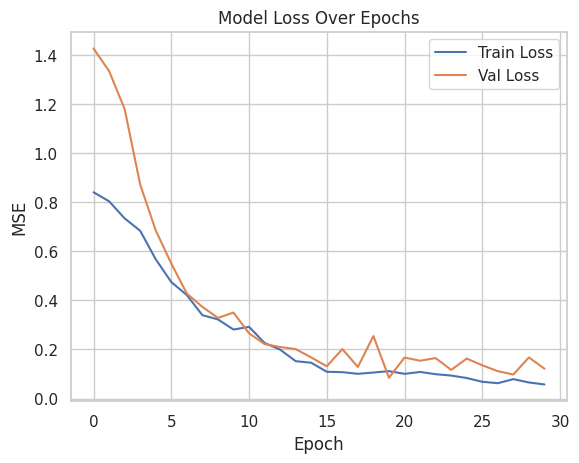

In [49]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()

# 📊 Summary Statistics from CMS Data Model

- Model Selection: Initially tested multiple models, but this LSTM-based model delivered the best performance for forecasting.

- 📄 Data Source: Used Sheet 1 (D1: Medicare Part D Drug Utilization - Prescriptions) for model training and evaluation.

- 🔄 Purpose: Forecast future Medicare Part D utilization costs using LSTM based on historical trends, metric types, and plan categories.

- 🔧 Feature Engineering: Included Year_diff and Value_lag1 to better capture time-based dynamics within each metric-plan group.

- 📈 Approach: Built sequence-based LSTM model with standardized inputs to predict future drug utilization values.

- 🎯 Target Value Range: 0.78 to 48.8 million — the wide spread makes higher prediction error more tolerable.

- ✅ RMSE ≈ 5.66M — only ~11.6% of the maximum value, indicating a reasonable error margin.

- ✅ R² = 0.659 — model explains ~66% of variance, which is strong given the real-world nature of healthcare data and limited input features.

**Save CMS LSTM model**

In [50]:
import os
import joblib

os.makedirs('models', exist_ok=True)

# Save model
model.save('models/cms_lstm_model.h5', save_format='h5')

# Save scalers
joblib.dump(scaler_X, 'models/scaler_X.save')
joblib.dump(scaler_y, 'models/scaler_y.save')



['models/scaler_y.save']